## Current step:
Select data augmentation policies using a controller model trained with Proximal Policy Optimization reinforcement learning.  

Be sure that the model is improving with training, and policies which resulted in lower accuracy are less likely to be chosen.

# AutoAugment with Proximal Policy Optimization



In [0]:
from keras import models, layers, backend, initializers
import time
from google.colab import files

import PIL
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Using TensorFlow backend.


In [0]:
from sklearn import metrics

In [0]:
nReducedTrain = 2000
nValidation = 5000
nBigTrain = 25000

from keras import datasets
from keras.utils import to_categorical
np.random.seed(42)
(XtrainOriginal, ytrainOriginal), (Xtest, ytest) = datasets.cifar10.load_data()

ix = np.arange(len(XtrainOriginal))
np.random.shuffle(ix)
Xtrain = XtrainOriginal[ix[:nReducedTrain]]
ytrain = ytrainOriginal[ix[:nReducedTrain]]
ytrain = to_categorical(ytrain)


XtrainBig = XtrainOriginal[ix[:nBigTrain]] # Even using a reduced search
ytrainBig = ytrainOriginal[ix[:nBigTrain]] # space for final training
ytrainBig = to_categorical(ytrainBig)


Xval = XtrainOriginal[ix[-nValidation:]]
yval = ytrainOriginal[ix[-nValidation:]]
yval = to_categorical(yval)


ytest = to_categorical(ytest)


In [0]:
print (len(XtrainBig))
print (len(Xtest))

25000
10000


In [0]:
imageClasses = ["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck"]

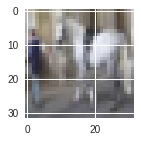

In [0]:
plt.figure(figsize=[2,2])
plt.imshow(Xtrain[0])

## Define Image Transformations

In [0]:
# Code below adapted from augmentation_transforms.py
# Modified to support transforms at the image class level
# Original copywright below:
# Copyright 2018 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
IMAGE_SIZE = 32
MEANS = [0.49139968, 0.48215841, 0.44653091]
STDS = [0.24703223, 0.24348513, 0.26158784]
PARAMETER_MAX = 10  # What is the max 'level' a transform could be predicted
#def pil_wrap(img):
#  """Convert the `img` numpy tensor to a PIL Image."""
#  return PIL.Image.fromarray(
#      np.uint8((img * STDS + MEANS) * 255.0)).convert('RGBA')
#def pil_unwrap(pil_img):
#  """Converts the PIL img to a numpy array."""
#  pic_array = (np.array(pil_img.getdata()).reshape((32, 32, 4)) / 255.0)
#  i1, i2 = np.where(pic_array[:, :, 3] == 0)
#  pic_array = (pic_array[:, :, :3] - MEANS) / STDS
#  pic_array[i1, i2] = [0, 0, 0]
#  return pic_array


def pil_wrap(X):
  X = X.reshape(32, 32, 3)
  X = np.uint8(X)
  return PIL.Image.fromarray(X)
def pil_unwrap(img):
  X = np.array(img.getdata()).reshape(32, 32, 3).astype(float)
  return X

# modified from https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
def create_cutout_mask(img_height, img_width, num_channels, size):
  """Creates a zero mask used for cutout of shape `img_height` x `img_width`.
  Args:
    img_height: Height of image cutout mask will be applied to.
    img_width: Width of image cutout mask will be applied to.
    num_channels: Number of channels in the image.
    size: Size of the zeros mask.
  Returns:
    A mask of shape `img_height` x `img_width` with all ones except for a
    square of zeros of shape `size` x `size`. This mask is meant to be
    elementwise multiplied with the original image. Additionally returns
    the `upper_coord` and `lower_coord` which specify where the cutout mask
    will be applied.
  """
  assert img_height == img_width
  # Sample center where cutout mask will be applied
  height_loc = np.random.randint(low=0, high=img_height)
  width_loc = np.random.randint(low=0, high=img_width)
  # Determine upper right and lower left corners of patch
  upper_coord = (max(0, height_loc - size // 2), max(0, width_loc - size // 2))
  lower_coord = (min(img_height, height_loc + size // 2),
                 min(img_width, width_loc + size // 2))
  mask_height = lower_coord[0] - upper_coord[0]
  mask_width = lower_coord[1] - upper_coord[1]
  assert mask_height > 0
  assert mask_width > 0
  mask = np.ones((img_height, img_width, num_channels))
  zeros = np.zeros((mask_height, mask_width, num_channels))
  mask[upper_coord[0]:lower_coord[0], upper_coord[1]:lower_coord[1], :] = (
      zeros)
  return mask, upper_coord, lower_coord
def cutout_numpy(img, size=16):
  """Apply cutout with mask of shape `size` x `size` to `img`.
  The cutout operation is from the paper https://arxiv.org/abs/1708.04552.
  This operation applies a `size`x`size` mask of zeros to a random location
  within `img`.
  Args:
    img: Numpy image that cutout will be applied to.
    size: Height/width of the cutout mask that will be
  Returns:
    A numpy tensor that is the result of applying the cutout mask to `img`.
  """
  img_height, img_width, num_channels = (img.shape[0], img.shape[1],
                                         img.shape[2])
  assert len(img.shape) == 3
  mask, _, _ = create_cutout_mask(img_height, img_width, num_channels, size)
  return img * mask
def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .
  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.
  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / PARAMETER_MAX
def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .
  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.
  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / PARAMETER_MAX)
def _cutout_pil_impl(pil_img, level):
  """Apply cutout to pil_img at the specified level."""
  size = int_parameter(level, 20)
  if size <= 0:
    return pil_img
  img_height, img_width, num_channels = (32, 32, 3)
  _, upper_coord, lower_coord = (
      create_cutout_mask(img_height, img_width, num_channels, size))
  pixels = pil_img.load()  # create the pixel map
  for i in range(upper_coord[0], lower_coord[0]):  # for every col:
    for j in range(upper_coord[1], lower_coord[1]):  # For every row
      pixels[i, j] = (125, 122, 113, 0)  # set the colour accordingly
  return pil_img
def _enhancer_impl(enhancer):
  """Sets level to be between 0.1 and 1.8 for ImageEnhance transforms of PIL."""
  def impl(pil_img, level):
    v = float_parameter(level, 1.8) + .1  # going to 0 just destroys it
    return enhancer(pil_img).enhance(v)
  return impl
# =============================================================================
def ShearX(img, v):  # [-0.3, 0.3]
    v = float_parameter(v, 0.3)
    if np.random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))
  
def ShearY(img, v):  # [-0.3, 0.3]
    v = float_parameter(v, 0.3)
    if np.random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))  
  
def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    v = int_parameter(v, 10)
    if np.random.random() > 0.5:
      v = -v
    return img.transform((32, 32), PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))
def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    v = int_parameter(v, 10)
    if np.random.random() > 0.5:
      v = -v
    return img.transform((32, 32), PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))
def Rotate(img, v):  # [-30, 30]
    v = int_parameter(v, 30)
    if np.random.random() > 0.5:
      v = -v
    return img.rotate(v)
def AutoContrast(img, _):
    #return PIL.ImageOps.autocontrast(img.convert('RGB')).convert('RGBA')
    return PIL.ImageOps.autocontrast(img)
def Invert(img, _):
    #return PIL.ImageOps.invert(img.convert('RGB')).convert('RGBA')
    return PIL.ImageOps.invert(img)
def Equalize(img, _):
    #return PIL.ImageOps.equalize(img.convert('RGB')).convert('RGBA')
    return PIL.ImageOps.equalize(img)
def Flip_LR(img, _):  # not from the paper
    return img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
def Flip_UD(img, _):
    return img.transpose(PIL.Image.FLIP_TOP_BOTTOM)
  
def Solarize(img, v):  # [0, 256]
    v = int_parameter(v, 256)
    #return PIL.ImageOps.solarize(img.convert('RGB'), 256 - v).convert('RGBA')
    return PIL.ImageOps.solarize(img, 256 - v)
def Posterize(img, v):  # [4, 8]
    v = int_parameter(v, 4)
    #return PIL.ImageOps.posterize(img.convert('RGB'), 4 - v).convert('RGBA')
    return PIL.ImageOps.posterize(img, 4 - v)
def Contrast(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Contrast)(img, v)
def Blur(img, v):
    return img.filter(PIL.ImageFilter.BLUR)
  
def Color(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Color)(img, v)
def Smooth(img, v):
    return img.filter(PIL.ImageFilter.SMOOTH)
  
def Brightness(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Brightness)(img, v)
def Sharpness(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Sharpness)(img, v)
def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    return _cutout_pil_impl(img, v)
def Crop(img, v, interpolation=PIL.Image.BILINEAR):
    cropped = img.crop((v, v, IMAGE_SIZE - v, IMAGE_SIZE - v))
    resized = cropped.resize((IMAGE_SIZE, IMAGE_SIZE), interpolation)
    return resized
def Identity(img, v):
  return img
  
opmap = {
    'Flip_LR' : Flip_LR,
    'Flip_UD' : Flip_UD,
    'AutoContrast' : AutoContrast,
    'Equalize' : Equalize,
    'Invert' : Invert,
    'Rotate' : Rotate,
    'Posterize' : Posterize,
    'Crop' : Crop,
    'Solarize' : Solarize,
    'Color' : Color,
    'Contrast' : Contrast,
    'Brightness' : Brightness,
    'Sharpness' : Sharpness,
    'ShearX' : ShearX,
    'ShearY' : ShearY,
    'TranslateX' : TranslateX,
    'TranslateY' : TranslateY,
    'Cutout' : Cutout,
    'Blur' : Blur,
    'Smooth' : Smooth,
    'Identity': Identity
}
transformList = list(opmap.values())
transformNames = [str(t).split(' ')[1] for t in transformList]

In [0]:
len(transformList)
transformNames

['Flip_LR',
 'Flip_UD',
 'AutoContrast',
 'Equalize',
 'Invert',
 'Rotate',
 'Posterize',
 'Crop',
 'Solarize',
 'Color',
 'Contrast',
 'Brightness',
 'Sharpness',
 'ShearX',
 'ShearY',
 'TranslateX',
 'TranslateY',
 'Cutout',
 'Blur',
 'Smooth',
 'Identity']

## Define Operation, Subpolicy classes, autoaugment generator

In [0]:
class Autoaugmentor():
  def __init__(self, X, Y, transforms, probabilities=None, batch_size=32, nClasses=None):
    self.X = X
    self.Y = Y
    self.transforms = transforms
    self.batch_size = batch_size
    self.nClasses = nClasses
    if probabilities is None:
      assert nClasses is not None
      probabilities = np.ones([nClasses, len(transforms)])
    else:
      self.setProbabilities(probabilities)
          
  def setProbabilities(self, probabilities):
    self.probabilities = probabilities / probabilities.sum(axis=1)[:, np.newaxis]
    
  def generator(self):
    while True:
        ix = np.arange(len(self.X))
        np.random.shuffle(ix)
        for i in range(len(self.X) // self.batch_size):
            _ix = ix[i*self.batch_size:(i+1)*self.batch_size]
            _X = self.X[_ix]
            _Y = self.Y[_ix]

            transformedX = []
            for j in range(len(_X)):
              whichClass = np.argmax(_Y[j])
              probs = self.probabilities[whichClass]
              magnitude = np.random.choice(10)
              whichTransform = np.random.choice(self.transforms, p=probs)
              pilX = PIL.Image.fromarray(_X[j])
              pilX = whichTransform(pilX, magnitude)
              transformedX.append(np.array(pilX))
            yield np.array(transformedX), _Y




In [0]:

def autoaugment(X, Y, transforms, probabilities=None, batch_size=32, nClasses=None):
  """
  Generates batches of (transformedX, Y) by selecting a function
  from the list transforms, according to the 2d array probabilities
  
  Args:
    X: list or array of np.arrays representing an image
    Y: list or array of labels, one-hot encoded allowed
    transforms: list of functions which take an array _X and magnitude, and
                return a new array the same shape at _X
    probabilities: None or 2-d array of shape [nClasses, nTransforms]
                   If None is passed, a uniform probability table is created
    batch_size: int - how many sets of _X, y to yield at a time
    nClasses: None or int: If no probabilities table is passed, this is used
                           to determine the shape of the probability table
  
  For each _X, _y pair, which of the functions in the list transforms
  to apply to _X is based on the _yth row of the probabilities table. 
  """
  
  if probabilities is None:
    assert nClasses is not None
    probabilities = np.ones([nClasses, len(transforms)])
    
  normalizedProbs = probabilities / probabilities.sum(axis=1)[:, np.newaxis]
  while True:
      ix = np.arange(len(X))
      np.random.shuffle(ix)
      for i in range(len(X) // batch_size):
          _ix = ix[i*batch_size:(i+1)*batch_size]
          _X = X[_ix]
          _Y = Y[_ix]
          
          
          transformedX = []
          for j in range(len(_X)):
            whichClass = np.argmax(_Y[j])
            probs = normalizedProbs[whichClass]
            magnitude = np.random.choice(10)
            whichTransform = np.random.choice(transforms, p=probs)

            pilX = PIL.Image.fromarray(_X[j])
            pilX = whichTransform(pilX, magnitude)
            transformedX.append(np.array(pilX))
          yield np.array(transformedX), _Y


## Display the transformations
### (Just to see what they look like)

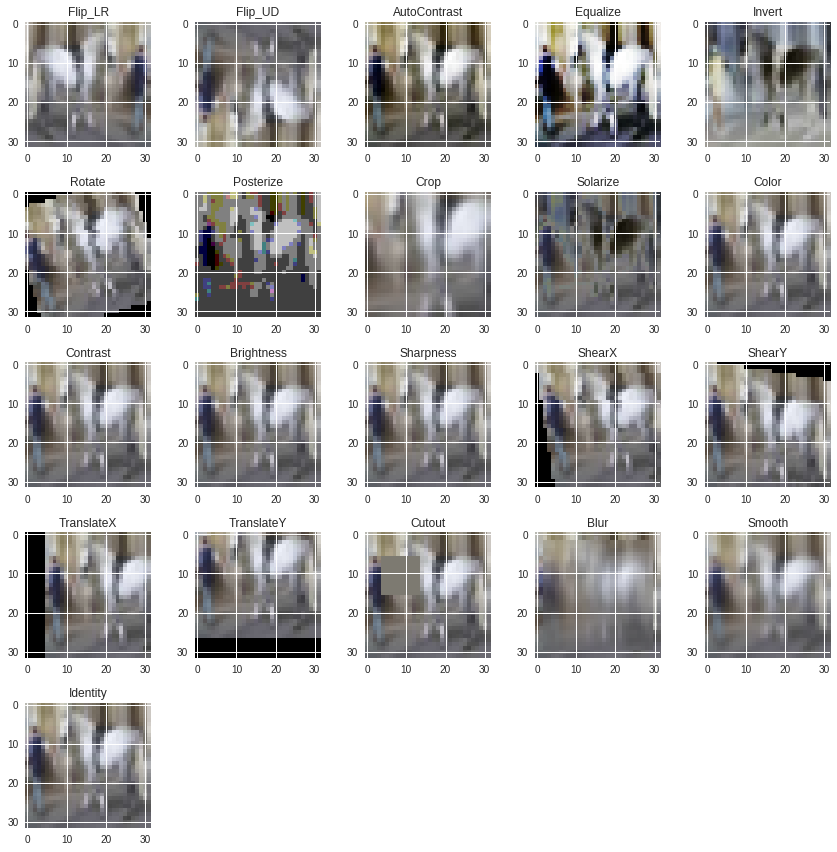

In [0]:
plt.figure(figsize=[12,12])

for i, op in enumerate(transformList):
  newX = op(PIL.Image.fromarray(Xtrain[0]), 5)
  plt.subplot(5,5, i+1)
  plt.title(str(op).split(' ')[1])
  plt.imshow(newX)
plt.tight_layout()

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.losses import categorical_crossentropy
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import rmsprop

class Child():
  def __init__(self, epochs=128, batchSize=500, inputShape=[32,32,3],
              num_classes=10, lr=1e-4, quick=False):
    # architecture from: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

    self.epochs = epochs
    self.batchSize = batchSize
    self.inputShape = inputShape
    self.lr = lr
    self.num_classes = num_classes
    self.buildModel()
    self.resetWeights = self.model.get_weights()
    
    
  def buildModel(self):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=self.inputShape, activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(self.num_classes, activation='softmax'))

      
    # initiate RMSprop optimizer
    opt = rmsprop(lr=self.lr, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])
    self.model = model
  
  def resetModel(self):
    opt = rmsprop(lr=self.lr, decay=1e-6)

    self.model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])
    self.model.set_weights(self.resetWeights)
    
  def fit(self, generator, stepsPerEpoch, verbose=0):
    self.model.fit_generator(generator,
                             steps_per_epoch = stepsPerEpoch,
                             epochs=self.epochs,
                             use_multiprocessing=False,
                             verbose=verbose)

  def evaluateByClass(self, X, Y):
    """
    Predicts Y and returns the recall score for each image class
    """
    prediction = self.model.predict(X)
    y_pred = np.argmax(prediction, axis=1)
    y_true = np.argmax(Y, axis=1)
    
    recallScores = []
    for i in range(self.num_classes):
      ix = y_true == i
      recall = (y_pred[ix] == i).mean()
      recallScores.append(recall)
    return np.array(recallScores)
  
  def evaluate(self, X, Y, verbose=0):
    """
    Returns the overall accuracy of the model on all
    passed validation data
    """
    return self.model.evaluate(X, Y, verbose=verbose)[1]
    



In [0]:
from keras import models, layers, initializers
import tensorflow as tf

    
class Controller():
  
    def __init__(self, nClasses=10, transformsPicked=None, nTransforms=8,
                 denseUnits=100, epochs=32,
                 minibatchSize=8, lr=1e-2, epsilon = .3,
                ):

      """
      Controller object which generates transformation policies      
      
      Consists of a neural net which takes a constant "dummy" input state
      Feeds through a LSTM, then a set of parallel dense layers with
      softmax activation.  
      
      Each image class has a softmax layer nTransforms long, from which 
      we sample transformsPicked times. The more often a transform is sampled,
      the more frequently the image class will be put through that transform
      during data augmentation

      Args:
      
      nClasses: int for how many different classes to produce probabilities for

      transformsPicked: int or None, indicating how many discrete samples to 
                        draw from each softmax probabiliites. If None, will 
                        default to the number of transforms
      
      nTransforms: int, number of possible transforms from which to choose. 
                   Sets the number of nodes in the final, parallel dense 
                   softmax layers
                   
      denseUnits: The output dimension of the initial fully connected layer
      
      minibatchSize: How many times to sample policies and train a child model
                     before fitting
                     
      lr: Learning rate for the controller optimizer
      
      epislon: float [0 - 1.], sets how far the policy can change each step.
               Comes from the Proximal Policy Optimization - Clipped algorithm
                      
                   
      """
      
      self.nClasses = nClasses
      self.denseUnits = denseUnits
      self.minibatchSize = minibatchSize
      self.lr = lr
      self.epochs=epochs
      self.nTransforms = nTransforms

      self.transformsPicked = transformsPicked
      if transformsPicked is None:
        self.transformsPicked = self.nTransforms
      
      
      self.softmaxCache = None
      self.epsilon = tf.constant(epsilon, dtype=tf.float32)
      self.buildModel()
      
    def buildModel(self):

      """
      Builds the neural net to generate policy probabilities.
      
      Starts with a dummy state input, goes through a dense layer
      before ending in nClasses parallel dense, softmax layers with nTransforms
      nodes.
      
      Uses Adam optimizer, and PPO-Clip
      """


      self.softmaxOutputs = []
      
      
      # *************
        
      self.input_ph = tf.keras.Input(shape=([1]),
                                     dtype=tf.float32,
                                     name='inputLayer')
      # does not take a batch size, unlike placeholders
      
      activity = self.input_ph
      activity = tf.keras.layers.Dense(self.denseUnits,
                                       use_bias=False,
                                      name='dense')(activity)
      # The input is always 1, so a linear activation without bias terms
      # will be fine

      for i in range(self.nClasses):
          nextSoftmax = tf.keras.layers.Dense(self.nTransforms,
                                          activation='softmax',
                                          kernel_initializer='uniform',
                                          name='class_'+str(i))
          self.softmaxOutputs.append(nextSoftmax(activity))
          # Each is [nBatch, nTransforms]
          
      allSoftmaxes = tf.stack(self.softmaxOutputs, axis=1)
      # This is now a tensor of shape [nBatch, nClasses, nTransforms]
      
      
      self.sampled_ph = tf.keras.backend.placeholder(
                           shape=(self.minibatchSize, self.nClasses, self.nTransforms),
                           dtype=tf.float32,
                           name='sampled_ph')
      # Indicates what proportion of transforms was chosen
      # [nBatch, nClasses, nTransforms]

      self.score_ph = tf.keras.backend.placeholder(shape=(self.minibatchSize,
                                                          self.nClasses),
                                                   dtype=tf.float32,
                                                  name='scores_ph')
      # [nBatch, nClasses]
      

      newLogProbs = tf.reduce_sum(tf.log(allSoftmaxes) * self.sampled_ph,
                                 axis=[2])      
      # Indicates the log probability of selecting the policy indicated
      # by self.selected_ph, according to the current softmaxes
      # shape [nBatch, nClasses]
      
      
      self.prevLogProb_ph = tf.keras.backend.placeholder(shape=(self.minibatchSize,
                                                               self.nClasses),
                                                         dtype=tf.float32,
                                                        name='prevLogPs_ph')
      # [nBatch, nClasses]

      
      differenceRatio = tf.exp(newLogProbs - self.prevLogProb_ph)
      clippedDifferenceRatio = tf.clip_by_value(differenceRatio,
                                                1-self.epsilon,
                                                1+self.epsilon)
      # each is [nBatch, nClasses]
      
      unClippedRatioScore = differenceRatio * self.score_ph
      clippedRatioScore = clippedDifferenceRatio * self.score_ph
      
      finalScore = tf.minimum(unClippedRatioScore, clippedRatioScore)
      loss = -tf.reduce_mean(finalScore)
      self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(loss)      

    def fit(self, selections, scores, logPs):
      """
      Fits the model based on a batch of data tuples,
      (selections, score, logPs)

      Args:
        selections: a list of nIterations arrays [nClasses, nTransforms] 
        indicating the ratio of which transforms were applied to each image class

        scores: an array of shape [nIterations, nClasses] indicating the
        recall score of each image class in that each iteration

        logPs: an array of shape [nItertions, nClasses] indicating the 
        log likelihood of the controller producing each class' selection
        according to the softmax values at the time it was sampled.
      """
      
      scoreMeans = scores.mean(axis=0)
#       scoreStds = scores.std(axis=0)
      normalizedScores = scores - scoreMeans
#       normalizedScores = normalizedScores / scoreStds
      
      session = backend.get_session()
      assert len(selections) >= self.minibatchSize
      assert len(scores) >= self.minibatchSize
      assert len(logPs) >= self.minibatchSize
      
      fd = {}
      fd[self.prevLogProb_ph] = logPs[-self.minibatchSize:]
      fd[self.sampled_ph] = selections[-self.minibatchSize:]
      fd[self.score_ph] = normalizedScores[-self.minibatchSize:]
      fd[self.input_ph] = np.ones([self.minibatchSize,1])
      
      for i in range(self.epochs):
        session.run(self.optimizer, feed_dict=fd)
      self.softmaxCache = None
      
      return self
    
    def getSoftmaxes(self):
      session = backend.get_session()
      softmaxes = session.run(self.softmaxOutputs,
                              feed_dict={self.input_ph:np.ones([1,1])})
      softmaxes = [np.squeeze(s) for s in softmaxes]
      self.softmaxCache = softmaxes
      return softmaxes
   
    def getPolicy(self, softmaxes=None):
      """
      Using the softmax outputs from the model's current weights (or passed
      softmax), 
      Draws self.transformsPicked samples from each image's softmax 
      probabilities treating them as a multinomial distribution.
      Returns this matrix of samples and the log probability of generating
      this exact sample for each image class.
      """
      if softmaxes is None:
        if self.softmaxCache is None:
          softmaxes = self.getSoftmaxes()
        else:
          softmaxes = self.softmaxCache
      
      selections = []
      logProbs = []
      for pvalues in softmaxes:
        if pvalues.sum() !=  1.:
          pvalues = np.clip(pvalues, 0.0, 1.0)
          pvalues = pvalues / pvalues.sum()
          # This shouldn't be necessary but occasionally, rounding
          # creates softmax layers that don't sum to 1
        pvalues = pvalues / pvalues.sum()
        sample = np.random.multinomial(self.transformsPicked,
                                               pvals=pvalues) / self.transformsPicked
        selections.append(sample)
        logP = np.log(pvalues)
        logProbs.append((sample * logP).sum())

      return np.array(selections), np.array(logProbs)



In [0]:
print ('Preparing Controller')
tic = time.time()
controller = Controller(nTransforms=len(transformList), transformsPicked=50,
                        minibatchSize=5, epochs=4, epsilon=.1, lr=1e-2)
toc = time.time()
print ("Controller ready, took %ds" % (toc-tic))



Preparing Controller
Controller ready, took 1s


In [0]:

recallScores = []
selectedSamples = []
logProbs = []
savedSoftmaxes = []


In [0]:

child = Child(epochs=32, batchSize=1000)
aa = Autoaugmentor(Xtrain, ytrain, transformList,
                   nClasses=10, batch_size=child.batchSize)

# Pretrain the model partway
child.model.fit(Xtrain, ytrain, epochs=32, batch_size=1000, verbose=0)
child.resetWeights = child.model.get_weights()


for i in range(5):

  print ("Iteration %d" % i, end =" ")
  tic = time.time()

  softmaxes = controller.getSoftmaxes()
  savedSoftmaxes.append(softmaxes)
  
  for policySample in range(controller.minibatchSize):
    print (" ... %d " %policySample, end=' ')
    transformSample, logP = controller.getPolicy(softmaxes)
    
    logProbs.append(logP)
    selectedSamples.append(transformSample)
    child.resetModel()
    aa.setProbabilities(transformSample)

    child.fit(aa.generator(), len(Xtrain) // child.batchSize)

    scores = child.evaluateByClass(Xval, yval)
    print('-> %.3f ' %scores.mean(), end = ' '),
    recallScores.append(scores)
  
  controller.fit(selectedSamples, np.array(recallScores), np.array(logProbs))
  toc = time.time()
  print (' - Total time: %d' %(toc-tic))
scoreArray = np.array(recallScores)
scoreArray.shape

Iteration 0  ... 0  -> 0.379   ... 1  -> 0.373   ... 2  -> 0.365   ... 3  -> 0.371   ... 4  -> 0.372   - Total time: 137
Iteration 1  ... 0  -> 0.372   ... 1  -> 0.378   ... 2  -> 0.390   ... 3  -> 0.378   ... 4  -> 0.384   - Total time: 144
Iteration 2  ... 0  -> 0.370   ... 1  -> 0.381   ... 2  -> 0.385   ... 3  -> 0.390   ... 4  -> 0.384   - Total time: 148
Iteration 3  ... 0  -> 0.384   ... 1  -> 0.362   ... 2  -> 0.376   ... 3  -> 0.372   ... 4  -> 0.383   - Total time: 155
Iteration 4  ... 0  -> 0.385   ... 1  -> 0.391   ... 2  -> 0.383   ... 3  -> 0.376   ... 4  -> 0.387   - Total time: 161


(25, 10)

## Check the controller's fitting

If the controller model is updating on the child model results, it should (broadly) learn to have a higher likelihood of producing the augmentation policies that had higher scores


Text(0.5,1,'Mean Recall Score of a Policy vs.\nLog Likelihood of Producing Policy')

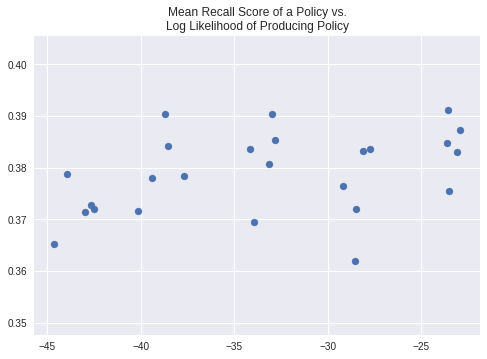

In [0]:
finalSoftmax = controller.getSoftmaxes()
scoreArray = np.array(recallScores)
newlogp = []
meanRecall = []
for i in range(len(scoreArray)):
  logp = (np.array(selectedSamples[i]) * np.log(finalSoftmax)).sum()
  newlogp.append(logp)
  meanRecall.append(scoreArray[i].mean())
  
plt.scatter(newlogp, meanRecall)
plt.title('Mean Recall Score of a Policy vs.\nLog Likelihood of Producing Policy')


In [118]:
newlogp = np.array(newlogp)
print (np.corrcoef(newlogp, meanRecall)[0,1])

0.37785342982127135


## Augmentation Policy

Text(0.5,1,'Augmentation Policy:\n%Chance of Picking Each Transform\nby Image Class')

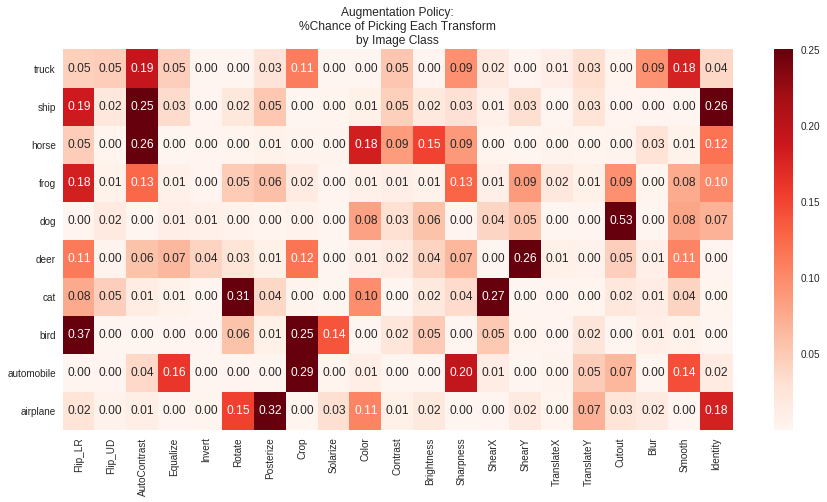

In [119]:

plt.figure(figsize=[15,7])
sns.heatmap(finalSoftmax, cmap='Reds', annot=True, fmt='.2f', vmax=.25)
xt = plt.xticks(np.arange(len(transformList))+.5, transformNames, rotation=90)
yt = plt.yticks(np.arange(10)+.5, imageClasses, rotation=0)
plt.title('Augmentation Policy:\n%Chance of Picking Each Transform\nby Image Class')


### Look at the average values, just for an interesting comparison to the 'classless' policy later

Text(0.5,1,'Split-Class Policy Averaged')

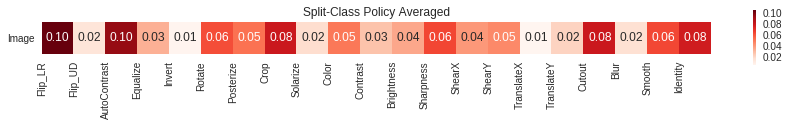

In [176]:

plt.figure(figsize=[15,1])
sns.heatmap(finalPolicy.mean(0)[np.newaxis, :], cmap='Reds', square=True, annot=True, fmt='.2f')
xt = plt.xticks(np.arange(len(transformList)), transformNames, rotation=90)
# yt = plt.yticks(np.arange(10)+.3, imageClasses, rotation=0)
yt = plt.yticks([.5], ['Image'], rotation=0)
plt.title('Split-Class Policy Averaged')


In [0]:
finalPolicy = np.array(finalSoftmax)
np.savetxt('finalPolicy.txt', finalPolicy)
# files.download('finalPolicy.txt')

# Test the policy

In [0]:
trainEpochs = 300
batchSize = 256

In [44]:
finalChild = Child(batchSize = batchSize, epochs=trainEpochs)
aa = Autoaugmentor(XtrainBig, ytrainBig, transformList,
                   nClasses=10, batch_size=batchSize)
aa.setProbabilities(finalPolicy)


finalChild.model.fit_generator(aa.generator(),
                       steps_per_epoch = len(XtrainBig) // batchSize,
                       epochs=trainEpochs,
                       validation_data=[Xval, yval],
                       use_multiprocessing=False, 
                       verbose=1)


Epoch 1/300
97/97 [==============================] - 16s 168ms/step - loss: 6.1514 - acc: 0.1291 - val_loss: 2.2129 - val_acc: 0.1902
Epoch 2/300
97/97 [==============================] - 9s 95ms/step - loss: 2.1700 - acc: 0.2122 - val_loss: 1.9687 - val_acc: 0.3062
Epoch 3/300
97/97 [==============================] - 10s 101ms/step - loss: 1.9696 - acc: 0.2846 - val_loss: 1.8243 - val_acc: 0.3520
Epoch 4/300
97/97 [==============================] - 10s 100ms/step - loss: 1.8644 - acc: 0.3191 - val_loss: 1.7221 - val_acc: 0.3964
Epoch 5/300
97/97 [==============================] - 10s 99ms/step - loss: 1.7960 - acc: 0.3455 - val_loss: 1.6826 - val_acc: 0.4038
Epoch 6/300
97/97 [==============================] - 10s 99ms/step - loss: 1.7492 - acc: 0.3677 - val_loss: 1.6886 - val_acc: 0.4052
Epoch 7/300
97/97 [==============================] - 10s 100ms/step - loss: 1.6991 - acc: 0.3878 - val_loss: 1.6235 - val_acc: 0.4182
Epoch 8/300
97/97 [==============================] - 10s 100ms/ste

In [0]:
np.savetxt('finalChildValAcc.txt', finalChild.model.history.history['val_acc'])

In [71]:
finalChild.model.evaluate(Xtest, ytest)

10000/10000 [==============================] - 10s 1ms/step


[0.7034417792797089, 0.779]

In [0]:
def modelEvaluation(model, Xtest, ytest):
  probs = model.predict_proba(Xtest)
  yhat = probs.argmax(1)

  normalizedProbs = probs / probs.mean(0)
  normalizedYhat = normalizedProbs.argmax(1)
  ytrue = ytest.argmax(1)
  return (yhat == ytrue).mean(), (normalizedYhat == ytrue).mean()

In [134]:
modelEvaluation(finalChild.model, Xtest, ytest)

(0.779, 0.7807)

In [160]:
noaugModel = Child() # No parameters because we're going to deal directly 
                     # with the model, no generator
  
noaugModel.model.fit(XtrainBig, ytrainBig, batch_size=batchSize,
                     epochs=trainEpochs,
                     validation_data=[Xval, yval],
                     verbose=1)
noaugModel.model.evaluate(Xtest, ytest)

Train on 25000 samples, validate on 5000 samples
Epoch 1/300
25000/25000 [==============================] - 16s 626us/step - loss: 7.6614 - acc: 0.1407 - val_loss: 2.1230 - val_acc: 0.2234
Epoch 2/300
25000/25000 [==============================] - 5s 185us/step - loss: 2.1178 - acc: 0.2304 - val_loss: 1.8651 - val_acc: 0.3406
Epoch 3/300
25000/25000 [==============================] - 5s 184us/step - loss: 1.8838 - acc: 0.3071 - val_loss: 1.7465 - val_acc: 0.3832
Epoch 4/300
25000/25000 [==============================] - 5s 184us/step - loss: 1.7617 - acc: 0.3550 - val_loss: 1.6380 - val_acc: 0.4190
Epoch 5/300
25000/25000 [==============================] - 5s 184us/step - loss: 1.6773 - acc: 0.3830 - val_loss: 1.5600 - val_acc: 0.4456
Epoch 6/300
25000/25000 [==============================] - 5s 184us/step - loss: 1.6099 - acc: 0.4133 - val_loss: 1.5276 - val_acc: 0.4476
Epoch 7/300
25000/25000 [==============================] - 5s 184us/step - loss: 1.5604 - acc: 0.4316 - val_loss: 1.

[1.0955568552970887, 0.7505]

In [162]:
np.savetxt('noaugValAcc.txt', noaugModel.model.history.history['val_acc'])

modelEvaluation(noaugModel.model, Xtest, ytest)
# # files.download('noaugValAcc.txt')

(0.7505, 0.7519)

In [0]:
# noaugval = np.loadtxt('noaugValAcc.txt')

In [51]:
len(noaugval)

300

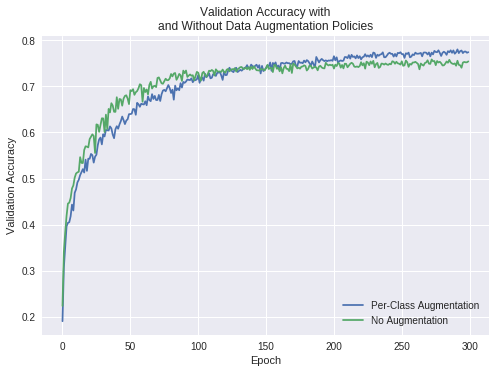

In [166]:
plt.title('Validation Accuracy with\nand Without Data Augmentation Policies')
plt.plot(finalChild.model.history.history['val_acc'], label='Per-Class Augmentation')
plt.plot(noaugModel.model.history.history['val_acc'], label='No Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

### Communist Policy

Ignore class, find the policy as though there were only one class

In [60]:
print ('Preparing Controller')
tic = time.time()
classless_controller = Controller(nTransforms=len(transformList), 
                                  nClasses = 1,
                                  transformsPicked=50,
                                  minibatchSize=5, epochs=4, epsilon=.1, lr=1e-2)
toc = time.time()
print ("Controller ready, took %ds" % (toc-tic))


classless_scores = []
classless_selectedSamples = []
classless_logProbs = []
classless_savedSoftmaxes = []


Preparing Controller
Controller ready, took 0s


In [61]:

# We already have the child and autoaugmentor from before

# child = Child(epochs=32, batchSize=1000)
# aa = Autoaugmentor(Xtrain, ytrain, transformList,
#                    nClasses=10, batch_size=child.batchSize)

# # Pretrain the model partway
# child.model.fit(Xtrain, ytrain, epochs=32, batch_size=1000, verbose=0)
# child.resetWeights = child.model.get_weights()


for i in range(5):

  print ("Iteration %d" % i, end =" ")
  tic = time.time()

  softmaxes = classless_controller.getSoftmaxes()
  classless_savedSoftmaxes.append(softmaxes)
  
  for policySample in range(classless_controller.minibatchSize):
    print (" ... %d " %policySample, end=' ')
    transformSample, logP = classless_controller.getPolicy(softmaxes)
    classless_logProbs.append(logP)
    classless_selectedSamples.append(transformSample)
    child.resetModel()
    
    fulltransformSample = np.ones([10, len(transformList)]) * transformSample
    
    
    aa.setProbabilities(fulltransformSample)

    child.fit(aa.generator(), len(Xtrain) // child.batchSize)

    scores = child.evaluate(Xval, yval)
    print('-> %.3f ' %scores.mean(), end = ' '),
    classless_scores.append([scores])
  
  classless_controller.fit(classless_selectedSamples,
                           np.array(classless_scores),
                           np.array(classless_logProbs))
  toc = time.time()
  print (' - Total time: %d' %(toc-tic))
classless_scoreArray = np.array(classless_scores)
classless_scoreArray.shape

Iteration 0  ... 0  -> 0.347   ... 1  -> 0.333   ... 2  -> 0.343   ... 3  -> 0.336   ... 4  -> 0.343   - Total time: 129
Iteration 1  ... 0  -> 0.346   ... 1  -> 0.348   ... 2  -> 0.322   ... 3  -> 0.335   ... 4  -> 0.337   - Total time: 127
Iteration 2  ... 0  -> 0.320   ... 1  -> 0.329   ... 2  -> 0.346   ... 3  -> 0.337   ... 4  -> 0.336   - Total time: 130
Iteration 3  ... 0  -> 0.353   ... 1  -> 0.357   ... 2  -> 0.353   ... 3  -> 0.350   ... 4  -> 0.343   - Total time: 138
Iteration 4  ... 0  -> 0.355   ... 1  -> 0.355   ... 2  -> 0.352   ... 3  -> 0.353   ... 4  -> 0.336   - Total time: 144


(25, 1)

In [0]:
classless_scoreArray = np.array(classless_scores)

classlessPolicy = np.array(classless_controller.getSoftmaxes())
classlessPolicy = np.ones([10, len(transformList)]) * classlessPolicy
np.savetxt('classlessPolicy.txt', classlessPolicy)

In [72]:
classlessChild = Child(batchSize = batchSize, epochs=trainEpochs)
aa = Autoaugmentor(XtrainBig, ytrainBig, transformList,
                   nClasses=10, batch_size=batchSize)
aa.setProbabilities(classlessPolicy)


classlessChild.model.fit_generator(aa.generator(),
                       steps_per_epoch = len(XtrainBig) // batchSize,
                       epochs=trainEpochs,
                       validation_data=[Xval, yval],
                       use_multiprocessing=False, 
                       verbose=1)


Epoch 1/300
97/97 [==============================] - 21s 217ms/step - loss: 4.9460 - acc: 0.1351 - val_loss: 2.1626 - val_acc: 0.2202
Epoch 2/300
97/97 [==============================] - 9s 96ms/step - loss: 2.1640 - acc: 0.2082 - val_loss: 1.9278 - val_acc: 0.3112
Epoch 3/300
97/97 [==============================] - 10s 102ms/step - loss: 2.0252 - acc: 0.2571 - val_loss: 1.8072 - val_acc: 0.3796
Epoch 4/300
97/97 [==============================] - 10s 101ms/step - loss: 1.9267 - acc: 0.2911 - val_loss: 1.6957 - val_acc: 0.4044
Epoch 5/300
97/97 [==============================] - 10s 102ms/step - loss: 1.8675 - acc: 0.3191 - val_loss: 1.6210 - val_acc: 0.4320
Epoch 6/300
97/97 [==============================] - 10s 105ms/step - loss: 1.8080 - acc: 0.3419 - val_loss: 1.5628 - val_acc: 0.4510
Epoch 7/300
97/97 [==============================] - 10s 104ms/step - loss: 1.7661 - acc: 0.3571 - val_loss: 1.5626 - val_acc: 0.4404
Epoch 8/300
97/97 [==============================] - 10s 103ms/s

In [0]:
np.savetxt('ClasslessChildValAcc.txt', classlessChild.model.history.history['val_acc'])

In [181]:
# classlessChild.model.evaluate(Xtest, ytest)
modelEvaluation(classlessChild.model, Xtest, ytest)

(0.7914, 0.7946)

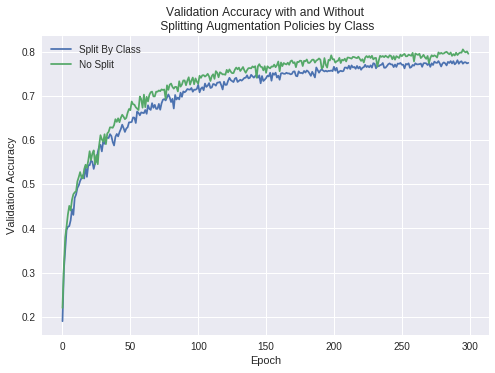

In [161]:
plt.title('Validation Accuracy with and Without\n Splitting Augmentation Policies by Class')
# plt.plot(corrModel.model.history.history['val_acc'], label='Correlation-Based Augmentation')
plt.plot(finalChild.model.history.history['val_acc'], label='Split By Class')
plt.plot(classlessChild.model.history.history['val_acc'], label='No Split')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

(0.4, 0.82)

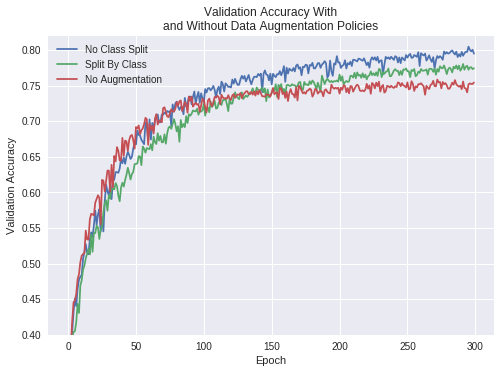

In [180]:
plt.title('Validation Accuracy With\nand Without Data Augmentation Policies')
plt.plot(classlessChild.model.history.history['val_acc'], label='No Class Split')
plt.plot(finalChild.model.history.history['val_acc'], label='Split By Class')
plt.plot(noaugModel.model.history.history['val_acc'], label='No Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.ylim([.4,.82])